### Load data

In [1]:
import pickle
with open('splitData.pickle', 'rb') as f:
    texts_train = pickle.load(f)
    texts_val = pickle.load(f)
    texts_test = pickle.load(f)
    labels_train = pickle.load(f)
    labels_val = pickle.load(f)
    labels_test = pickle.load(f)

all_texts  = texts_train  + texts_val  + texts_test
all_labels = labels_train + labels_val + labels_test
# check the ratio of each dataset
total = len(texts_train) + len(texts_val) + len(texts_test)
len(texts_train)/total, len(texts_val)/total, len(texts_test)/total

(0.5997757847533632, 0.20011210762331838, 0.20011210762331838)

# Q2-Clustering

### Step 0: Vectorise text

In [2]:
import spacy

nlp = spacy.load('en_core_web_sm') # can tokenize other languages like Spanish at least

# additional stop words to be removed during pipeline
added_stop_words = set(["ayy","ay","ah","oh","ohh","ooh","la","da","dum","ll","d","m","ve","yah","yeah"])
my_stop_words = nlp.Defaults.stop_words.union(added_stop_words)


def text_pipeline_spacy(text):
    tokens = []
    doc = nlp(text)
    for t in doc:
        if not t.is_stop and not t.is_punct and not t.is_space and not t in my_stop_words:
            tokens.append(t.lemma_.lower())
    return tokens

# Check pipiline:
text_pipeline_spacy("Of all the things I miss, I miss my mind the most.")

['thing', 'miss', 'miss', 'mind']

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=text_pipeline_spacy, stop_words=my_stop_words)

texts_vector = vectorizer.fit_transform(all_texts)
texts_vector.shape

(1784, 19605)

## Conducting Kmeans

In [4]:
import numpy as np
np.random.seed(42)
def kmeans(k, matrix, max_iter=300):
    num_data, dim_feature = matrix.shape

    # Step1: pick k random centroids
    #### centroids = np.random.random([k,22406])  # Random Partition --- does not work well
    #Use Forgy partition to make sure at least one point is allocated to one point
    centroids = matrix[np.random.randint(0,num_data,k)]


    # new centroids to be calculated
    new_centroids = np.zeros((k,dim_feature))

    # labels(=index of centroids) assigned to data
    labels = np.zeros(num_data)

    # iterate until convergence or max_iteration
    for itr in range(max_iter):
        
        # iterate through all data
        for i in range(num_data):
            # matrix is a sparse vector, so make it dense array
            ith_vec = np.squeeze(np.asarray(matrix[i].todense()))

            #Step2: Assign each vector to its closest centroid
            dists = np.sum(np.square(centroids - ith_vec), axis=1)
            labels[i] = np.argmin(dists)

        #Step3:Recalculate the centroids
        for j in range(k):
            new_centroids[j] = matrix[labels==j].mean(axis=0)

        # If step 2 and 3 converges, exit for-loop         
        if np.all(new_centroids == centroids):
            print("converged")
            break;
        centroids = new_centroids

    return labels, new_centroids


clustered_labels, centroids = kmeans(5,texts_vector)
from collections import Counter
clustered_labels = [int(l) for l in clustered_labels]
Counter(clustered_labels)

converged


Counter({3: 689, 0: 885, 1: 130, 2: 20, 4: 60})

### For answering questions

In [5]:
# question a) show documents assigned to eatch cluster
shown = {} # labels checked
doc_samples = [[] for _ in range(5)]# documents sampled
for idx,l in enumerate(clustered_labels):
    if(shown.get(l,0) < 3):
        shown[l] = shown.get(l,0)+1
        doc_samples[l].append(all_texts[idx])
    
for label,docs in enumerate(doc_samples):
    print(f'\n=======label{label}=======')
    for i in range(3):
        print(f'{i}th docs')
        print(docs[i][:120])
        print('------------------')





=======label0=======
0th docs
Moonlight
Lyrics
The sun is setting and you're right here by my side
And the movie is playing, but we won't be watching 
------------------
1th docs
Shady XV
Shady XV Lyrics
I'm liable to start a violent spark with a silent thought
I disgust you like dialogue from The 
------------------
2th docs
Write Your Name
Write Your Name Lyrics
Take my arm, take my head
Make your mark like a man
Write your name
Gonna write y
------------------

=======label1=======
0th docs
On the Floor (Mixin Marc & Tony Svejda L.A. to Ibiza Mix)
On the Floor (Mixin Marc & Tony Svejda L.A. to Ibiza Mix) Lyri
------------------
1th docs
​in my head
Grande - in my head (Srpski Prevod)PortuguêsAriana Grande - in my head (polskie tłumaczenie)ItalianoDeutschف
------------------
2th docs
Don’t Walk Away
Don’t Walk Away Lyrics
Ooh, don't walk away
Walk away

Don't walk away
See, I just can't find the right 
------------------

=======label2=======
0th docs
INUYASHA
Lyrics
Damn, baby, wha

In [6]:
# question a) show words that are common to each cluster
for i in range(5):
    print(f"------top 5 tokens in centroid {i}-----")
    indices = np.argsort(centroids[i])[-5:] # indices of most prominent tokens
    for key,val in vectorizer.vocabulary_.items():
        if val in indices:
            print(f'{key}',end=",")
    print("\n")


------top 5 tokens in centroid 0-----
know,feel,like,fuck,let,

------top 5 tokens in centroid 1-----
stay,bitch,away,work,walk,

------top 5 tokens in centroid 2-----
animal,jump,damn,glad,effect,

------top 5 tokens in centroid 3-----
want,know,love,like,baby,

------top 5 tokens in centroid 4-----
like,people,world,woman,million,



In [7]:
# question c) construct a confusion matrix
# correspond labels(songer names) with integers

label2id = {"Beyonce Knowles":0,
            "Michael Jackson":1,
            "Lady Gaga":2,
            "Taylor Swift":3,
            "Ariana Grande":4,
            "Selena Gomez":5,
            "Eminem":6,
            "Jennifer Lopez":7,
            "Dua Lipa":8,
            "XXXTentacion":9}
#label2id = {label: i for i, label in enumerate(set(labels_train))} 
#enumerate is environmentally dependent so, substituted by avove
id2label = {id:label for label,id in label2id.items()}

print(Counter(clustered_labels))

cm = [[0 for _ in range(5)] for _ in range(10)]
for idx, label in enumerate(all_labels):
    true_id = label2id[label] 
    pred_id = clustered_labels[idx]
    cm[true_id][pred_id] += 1
cm = np.array(cm)
np.sum(cm,axis=0) #Just to check aggregation is correctly done

Counter({0: 885, 3: 689, 1: 130, 4: 60, 2: 20})


array([885, 130,  20, 689,  60])

<AxesSubplot:xlabel='k-means labels', ylabel='Target labels'>

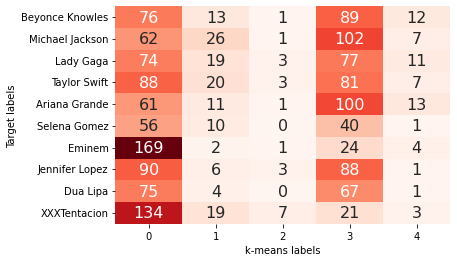

In [8]:
# show confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sn

def plotConfusionMatrix(cm, labels_val, labels_predicted):
  cm = cm
  colour_map = sn.color_palette("Reds", as_cmap=True)
  labels_x = labels_val
  labels_y = labels_predicted #list(label2id.keys())#['Eminem', 'Beyonce Knowles', 'Dua Lipa', 'Selena Gomez', 'Michael Jackson', 'Ariana Grande', 'Taylor Swift', 'Lady Gaga', 'XXXTentacion', 'Jennifer Lopez']
  plot = sn.heatmap(cm, 
                    annot=True, # Put the numbers in
                    annot_kws={"size": 16}, # Make the numbers bigger
                    fmt='g', # Stop scientific notation
                    cmap = colour_map, # Choose the colour palette
                    cbar = False, # Don't include the colour bar
                    xticklabels=labels_x,#labels_x, # Put in the X and Y labels
                    yticklabels=labels_y)
  plot.set(xlabel='k-means labels', ylabel='Target labels')
  return plot

plotConfusionMatrix(cm, [str(i) for i in range(5)] ,list(label2id.keys()))

# Q3-Comparing Classifiers

In [9]:
# Show classifier performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def showPerformance(labels_true, labels_predicted):
    print(f'accuracy ={accuracy_score(labels_true, labels_predicted):.3f}')
    print(f'precision={precision_score(labels_true, labels_predicted, average="macro"):.3f}')
    print(f'recall   ={recall_score(labels_true, labels_predicted, average="macro"):.3f}') 
    print(f'f1       ={f1_score(labels_true, labels_predicted, average="macro"):.3f}')
    return ;


### Dummy Classifier with strategy="most_frequent"

In [10]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(texts_train,labels_train)
labels_predicted = dummy_clf.predict(texts_val)

print(dummy_clf.score(texts_val, labels_val))
print("on validation")
showPerformance(labels_val, labels_predicted)
print("\non training")
showPerformance(labels_train, dummy_clf.predict(texts_train))

0.08403361344537816
on validation
accuracy =0.084
precision=0.008
recall   =0.100
f1       =0.016

on training
accuracy =0.127
precision=0.013
recall   =0.100
f1       =0.023


/home/denjo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/denjo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Dummy Classifier with strategy="stratified"

In [27]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(texts_train,labels_train)
labels_predicted = dummy_clf.predict(texts_val)

showPerformance(labels_val, labels_predicted)

print("\non training")
showPerformance(labels_train, dummy_clf.predict(texts_train))

accuracy =0.101
precision=0.099
recall   =0.096
f1       =0.096

on training
accuracy =0.089
precision=0.087
recall   =0.086
f1       =0.086


### LogisticRegression with one-hot vectorization

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
vectorizer = CountVectorizer(tokenizer=text_pipeline_spacy,stop_words=my_stop_words)

vect_texts_train = vectorizer.fit_transform(texts_train)
vect_texts_train[vect_texts_train != 0] = 1 # convert non-zero counting into 1

vect_texts_val = vectorizer.transform(texts_val)
vect_texts_val[vect_texts_val != 0] = 1

# Logistic Regression
clf = LogisticRegression(random_state=42,max_iter=1000).fit(vect_texts_train, labels_train)
labels_predicted = clf.predict(vect_texts_val)


showPerformance(labels_val, labels_predicted)

print("\non training")
showPerformance(labels_train, clf.predict(vect_texts_train))

accuracy =0.560
precision=0.563
recall   =0.564
f1       =0.554

on training
accuracy =1.000
precision=1.000
recall   =1.000
f1       =1.000


### LogisticRegression with TF-IDF vectorization

In [29]:
vectorizer = TfidfVectorizer(tokenizer=text_pipeline_spacy,stop_words=my_stop_words)
vect_texts_train = vectorizer.fit_transform(texts_train)
vect_texts_val = vectorizer.transform(texts_val)

# Logistic Regression
clf = LogisticRegression(random_state=42).fit(vect_texts_train, labels_train)
labels_predicted = clf.predict(vect_texts_val)


showPerformance(labels_val, labels_predicted)

print("\non training")
showPerformance(labels_train, clf.predict(vect_texts_train))


accuracy =0.457
precision=0.434
recall   =0.451
f1       =0.421

on training
accuracy =0.921
precision=0.931
recall   =0.895
f1       =0.902


/home/denjo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SVC Classifier with One-hot vectorization

In [30]:
# making one-hot vectors
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer=text_pipeline_spacy,stop_words=my_stop_words)
vect_texts_train = vectorizer.fit_transform(texts_train)
vect_texts_train[vect_texts_train != 0] = 1 # convert non-zero counting into 1

vect_texts_val = vectorizer.transform(texts_val)
vect_texts_val[vect_texts_val != 0] = 1

from sklearn.svm import SVC
clf = SVC(random_state=42).fit(vect_texts_train, labels_train)
labels_predicted = clf.predict(vect_texts_val)


showPerformance(labels_val, labels_predicted)

print("\non training")
showPerformance(labels_train, clf.predict(vect_texts_train))

accuracy =0.499
precision=0.493
recall   =0.496
f1       =0.466

on training


/home/denjo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy =0.927
precision=0.940
recall   =0.902
f1       =0.910


#### bar chart for F1 scores in LR with One-hot

In [31]:
# calculate labels again
vectorizer = CountVectorizer(tokenizer=text_pipeline_spacy,stop_words=my_stop_words)

vect_texts_train = vectorizer.fit_transform(texts_train)
vect_texts_train[vect_texts_train != 0] = 1 # convert non-zero counting into 1
vect_texts_val = vectorizer.transform(texts_val)
vect_texts_val[vect_texts_val != 0] = 1
# Logistic Regression
clf = LogisticRegression(random_state=42,max_iter=1000).fit(vect_texts_train, labels_train)
labels_predicted = clf.predict(vect_texts_val)


showPerformance(labels_val, labels_predicted)

accuracy =0.560
precision=0.563
recall   =0.564
f1       =0.554


/tmp/ipykernel_21142/3443738131.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


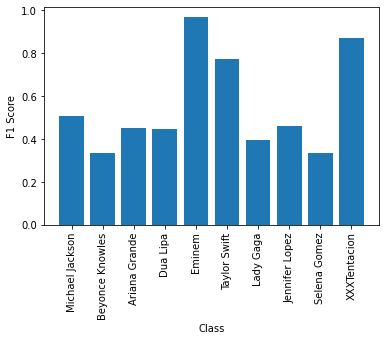

In [32]:
#a) drawing a bar chart for F1 scores
import matplotlib.pyplot as plt

# Calculate F1 score for each class
label_set = set(labels_val)
f1_scores = np.zeros(10)
for idx,l in enumerate(label_set):
    true_mask = np.array(labels_val) == l
    pred_mask = np.array(labels_predicted) == l
    f1_scores[idx] = f1_score(true_mask, pred_mask)

# Plot bar chart with F1 score for each class
fig = plt.figure()
ax = fig.add_subplot()
ax.bar(range(10), f1_scores)
ax.set_xlabel("Class")
ax.set_ylabel("F1 Score")
ax.set_xticks(range(10))

ax.set_xticklabels(list(label_set),rotation=90)
fig.savefig("./figures/F1score.png", bbox_inches="tight")
fig.show()


### b) Logistic Regression after Tf-Idf Vectorizer with Different Tokenizer.

In [33]:
# my tokenizer
def my_text_pipeline_spacy(text):
    tokens = []
    doc = nlp(text)
    for t in doc:
        # maintain punctuation, stopwords, Capital words
        if not t.is_space:
            tokens.append(t.lemma_)
    return tokens
vectorizer = TfidfVectorizer(tokenizer=my_text_pipeline_spacy)#tokenizer=None, stop_words=None,lowercase=False)
print(vectorizer.fit_transform(["Oh-oh-oh \tah ah"]).todense())
vectorizer.vocabulary_.keys()


[[0.48507125 0.48507125 0.72760688]]


dict_keys(['oh', '-', 'ah'])

In [34]:
vectorizer = TfidfVectorizer(tokenizer=my_text_pipeline_spacy)
vect_texts_train = vectorizer.fit_transform(texts_train)
vect_texts_val = vectorizer.transform(texts_val)

print(vect_texts_train.shape)
# Logistic Regression
clf = LogisticRegression(random_state=42).fit(vect_texts_train, labels_train)
labels_predicted = clf.predict(vect_texts_val)


showPerformance(labels_val, labels_predicted)

print("\non training")
showPerformance(labels_train, clf.predict(vect_texts_train))


(1070, 15354)
accuracy =0.443
precision=0.413
recall   =0.437
f1       =0.403

on training
accuracy =0.839
precision=0.854
recall   =0.805
f1       =0.812


/home/denjo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Q4-Parameter Tuning

#### choose C value

In [ ]:
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
param_C = {'C':np.logspace(-3,5,9,base=10.0)}

results = pd.DataFrame({"accuracy":[],
                        "precision":[],
                        "recall":[],
                        "F1":[]})

for params in tqdm(ParameterGrid(param_C)):
  # vectorize training set and validation set
  vectorizer = TfidfVectorizer(tokenizer=text_pipeline_spacy, stop_words=my_stop_words)
  vect_texts_train = vectorizer.fit_transform(texts_train)
  vect_texts_val = vectorizer.transform(texts_val)

  # logistic regression
  clf = LogisticRegression(random_state=42,C=params['C'],max_iter=1000).fit(vect_texts_train, labels_train)
  labels_predicted = clf.predict(vect_texts_val)

  results.loc[f"C={params['C']}"] = [accuracy_score(labels_val, labels_predicted),
                                     precision_score(labels_val,labels_predicted,average="macro"),
                                     recall_score(labels_val, labels_predicted, average="macro"),
                                     f1_score(labels_val, labels_predicted, average="macro")
                                    ]
results.round(3)



#### choose vectorizer

In [ ]:
param_vec = {'max_features':[None, 5, 50, 500, 5000, 50000], 'sublinear_tf':[True,False]}

results = pd.DataFrame({"accuracy":[],
                        "precision":[],
                        "recall":[],
                        "F1":[]})
for params in tqdm(ParameterGrid(param_vec)):
  # vectorize training set and validation set
  vectorizer = TfidfVectorizer(tokenizer=text_pipeline_spacy,stop_words=my_stop_words, max_features=params["max_features"], sublinear_tf=params["sublinear_tf"])
  vect_texts_train = vectorizer.fit_transform(texts_train)
  vect_texts_val = vectorizer.transform(texts_val)

  # logistic regression
  clf = LogisticRegression(random_state=42,C=10,max_iter=1000).fit(vect_texts_train, labels_train)
  labels_predicted = clf.predict(vect_texts_val)

  results.loc[f"MF={params['max_features']},SF={params['sublinear_tf']}"] = \
                                    [accuracy_score(labels_val, labels_predicted),
                                     precision_score(labels_val,labels_predicted,average="macro"),
                                     recall_score(labels_val, labels_predicted, average="macro"),
                                     f1_score(labels_val, labels_predicted, average="macro")
                                    ]
results.round(3)


#### Choose penalty 

In [ ]:
param_vec = {'penalty':['none','l2','l1','elasticnet']}

results = pd.DataFrame({"accuracy":[],
                        "precision":[],
                        "recall":[],
                        "F1":[]})
# vectorize training set and validation set
vectorizer = TfidfVectorizer(tokenizer=text_pipeline_spacy,stop_words=my_stop_words,max_features=5000, sublinear_tf=True)#, max_features=params["max_features"], sublinear_tf=params["sublinear_tf"])
vect_texts_train = vectorizer.fit_transform(texts_train)
vect_texts_val = vectorizer.transform(texts_val)

for params in tqdm(ParameterGrid(param_vec)):

  # logistic regression
  clf = LogisticRegression(random_state=42,C=10,max_iter=10000,penalty=params["penalty"],solver='saga',l1_ratio=0.5).fit(vect_texts_train, labels_train)
  labels_predicted = clf.predict(vect_texts_val)

  results.loc[f"param:{params['penalty']}"] =  \
                                    [accuracy_score(labels_val, labels_predicted),
                                     precision_score(labels_val,labels_predicted,average="macro"),
                                     recall_score(labels_val, labels_predicted, average="macro"),
                                     f1_score(labels_val, labels_predicted, average="macro")
                                    ]
results.round(3)